In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import os
import sklearn as sk
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths
from skimage import io
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
import tensorflow.keras.optimizers as optim
from tensorflow.keras import preprocessing as pp
from tensorflow.keras import callbacks as cb
import matplotlib.pyplot as plt
import pandas as pd
tf.__version__

'2.1.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Processamento das imagens usando Keras image preprocessing

Tive que mudar muita coisa para usar modelos pre-treinados,
como nao consegui usar as imagens direto, tive que refazer
o processamento de imagens. 

In [3]:
batch_size = 32
img_size = 224
seed=42
root_dir = "C:\\Users\\user\\Documents\\python\\pelagem_gatos\\imagens_unicas"

In [4]:
train_datagen = pp.image.ImageDataGenerator(rescale=1./255.,
                                            validation_split=0.2,
                                            featurewise_std_normalization=False,
                                            rotation_range=20,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            horizontal_flip=True,
                                            vertical_flip=False,
                                            brightness_range=[0.8,1.2]
                                            )

valid_datagen = pp.image.ImageDataGenerator(rescale=1./255, 
                                            validation_split=0.2,
                                            featurewise_std_normalization=False)



valid_gen = valid_datagen.flow_from_directory(root_dir, subset='validation',\
                                              shuffle=True, seed=seed, 
                                              target_size=(img_size,img_size),\
                                              batch_size=batch_size, color_mode='rgb')

train_gen = train_datagen.flow_from_directory(root_dir, subset='training',\
                          shuffle=True, seed=seed, target_size=(img_size,img_size),\
                          batch_size=batch_size, color_mode='rgb')

    

Found 936 images belonging to 9 classes.
Found 3759 images belonging to 9 classes.


**Mostra as imagens**

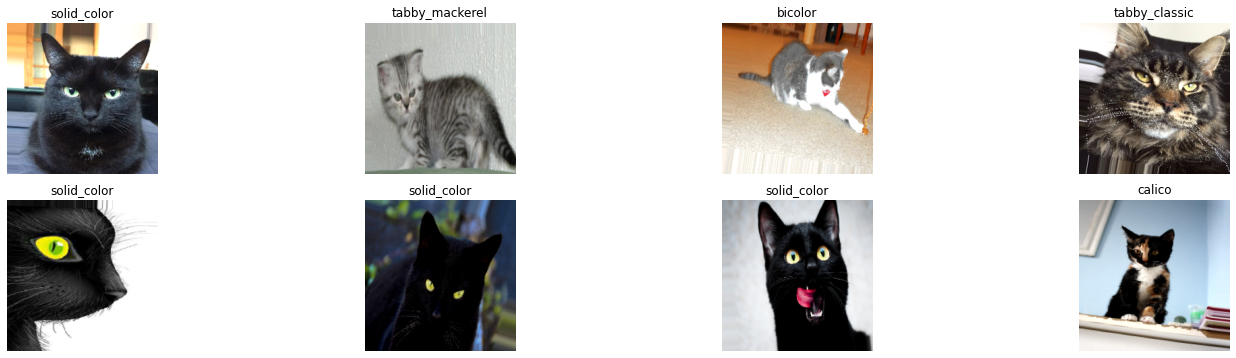

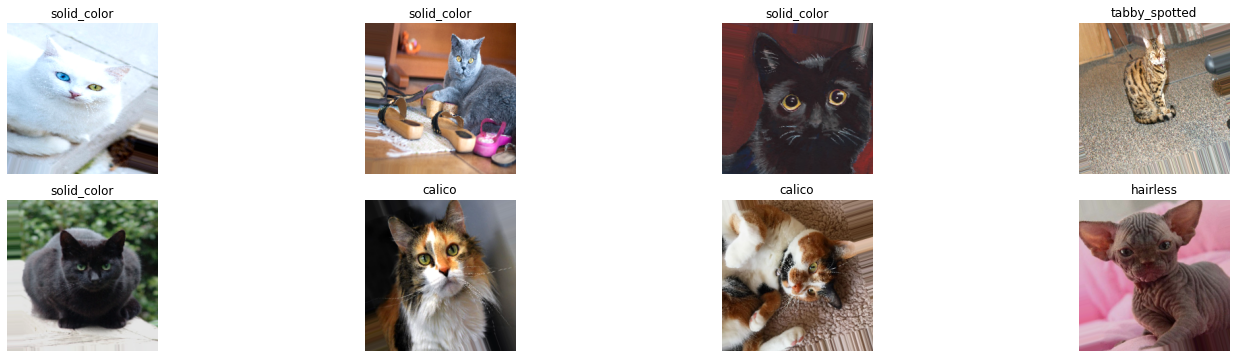

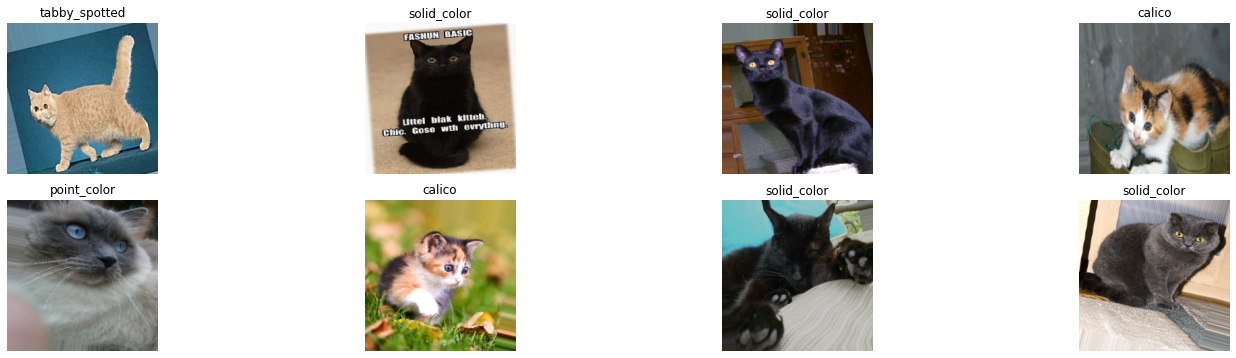

In [5]:
def decode(label): #Funcao para decodificar os labels (depois checa se os gatos estao com o label certo)
    nomes = ['bicolor',
             'calico',
             'hairless',
             'point_color',
             'solid_color',
             'tabby_classic',
             'tabby_mackerel',
             'tabby_spotted',
             'tortoiseshell']
    return nomes[np.argmax(label)]

# mostrar as imagens, tambem adaptado do codigo acima
def show_batch(images_, labels_):
    plt.figure(figsize=(20,10))
    for n in range(8):
        label = [x for x in labels_]
        image = [x for x in images_]
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image[n])
        plt.title(decode(label[n]))
        plt.axis('off')
        plt.tight_layout()
images_, labels_ = train_gen[0]
show_batch(images_, labels_)
images_, labels_ = train_gen[round(len(train_gen)/2)]
show_batch(images_, labels_)
images_, labels_ = train_gen[len(train_gen)-1]
show_batch(images_, labels_)

### Modelos ja treinados para imagenet
* https://keras.io/api/applications/
* MobileNetV2 e' menor e por isso ocupa menos espaco na memoria do celular

In [6]:

mobilenet = tf.keras.applications.MobileNetV2(include_top=True,
                                        weights="imagenet",
                                        input_shape = (img_size,img_size,3)
                                        )
"""

resnet50 = tf.keras.applications.ResNet50(include_top=True,
                            weights="imagenet",
                            input_shape = (224,224,3) #Usei o mesmo tamanho
                            ) 

efficientB3 = tf.keras.applications.EfficientNetB3(include_top=False,
                            weights="imagenet",
                            input_shape = (img_size,img_size,3) #Usei o mesmo tamanho
                            ) 
"""

'\n\nresnet50 = tf.keras.applications.ResNet50(include_top=True,\n                            weights="imagenet",\n                            input_shape = (224,224,3) #Usei o mesmo tamanho\n                            ) \n\nefficientB3 = tf.keras.applications.EfficientNetB3(include_top=False,\n                            weights="imagenet",\n                            input_shape = (img_size,img_size,3) #Usei o mesmo tamanho\n                            ) \n'

In [7]:
#cria o modelo, pode testar modelos diferentes da list do keras
model = tf.keras.Sequential()
model.add(mobilenet)
model.add(tf.keras.layers.Dense(1000,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(9,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1000)              3538984   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
Total params: 4,798,553
Trainable params: 4,764,441
Non-trainable params: 34,112
_________________________________________

## Treinamento
Como esses modelos ja sao pre-treinados, o melhor jeito e' treinar primeiro os layers que foram adicionados e depois treinar tudo com um learning rate bem pequeno.

O que fazer para melhorar.
* Tentar usar (freeze) no modelo e treinar so as novas camadas com lr alto, depois treinar tudo com lr baixo
* Mais imagens
* Checar se nao tem imagens repetidas ou imgens em classes erradas
* Usar Callback para salvar o melhor modelo antes do overfiting
* Tentar algumas imagens para test
* Efficient Nets sao de B0 - B7, dependendo da memoria, vai ter que usar uma rede menor


In [8]:
def train_model(lr, epochs, batch_size=32):
    
    opt = optim.Adam(learning_rate=lr, name='Adam')
    reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)
    e_stop=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=15, verbose=1, mode='auto',
                                restore_best_weights=True)

    model.compile(loss='categorical_crossentropy' ,
                  optimizer=opt, metrics=['AUC', 'CategoricalAccuracy'])
    
    with tf.device('/GPU:0'):
        history=model.fit(
                train_gen,
                steps_per_epoch= train_gen.samples // batch_size,
                epochs=epochs,
                validation_data= valid_gen,
                validation_steps= valid_gen.samples// batch_size, 
                callbacks=[reduce_lr,e_stop] 
                        
                )
    return history

In [9]:
history = train_model(lr=1e-4, epochs = 100) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 117 steps, validate for 29 steps
Epoch 1/100
 36/117 [========>.....................] - ETA: 1:16 - loss: 2.1887 - AUC: 0.6651 - CategoricalAccuracy: 0.3403

C:\Users\User\anaconda3\envs\gatos-gpu-tf21\lib\site-packages\PIL\Image.py:930: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


117/117 [==============================] - 119s 1s/step - loss: 2.0854 - AUC: 0.7606 - CategoricalAccuracy: 0.4263 - val_loss: 1.9045 - val_AUC: 0.8126 - val_CategoricalAccuracy: 0.5216
Epoch 2/100
117/117 [==============================] - 112s 961ms/step - loss: 1.5898 - AUC: 0.8821 - CategoricalAccuracy: 0.6147 - val_loss: 1.5852 - val_AUC: 0.8204 - val_CategoricalAccuracy: 0.5280
Epoch 3/100
117/117 [==============================] - 112s 958ms/step - loss: 0.9997 - AUC: 0.9384 - CategoricalAccuracy: 0.6976 - val_loss: 1.5970 - val_AUC: 0.8363 - val_CategoricalAccuracy: 0.6369
Epoch 4/100
117/117 [==============================] - 113s 962ms/step - loss: 0.7399 - AUC: 0.9575 - CategoricalAccuracy: 0.7880 - val_loss: 1.3931 - val_AUC: 0.8683 - val_CategoricalAccuracy: 0.6929
Epoch 5/100
117/117 [==============================] - 113s 962ms/step - loss: 0.6115 - AUC: 0.9652 - CategoricalAccuracy: 0.8248 - val_loss: 1.2014 - val_AUC: 0.9035 - val_CategoricalAccuracy: 0.7101
Epoch 6/10

Epoch 42/100
117/117 [==============================] - 112s 959ms/step - loss: 0.0496 - AUC: 0.9980 - CategoricalAccuracy: 0.9906 - val_loss: 0.7369 - val_AUC: 0.9484 - val_CategoricalAccuracy: 0.8427
Epoch 43/100
117/117 [==============================] - 113s 963ms/step - loss: 0.0463 - AUC: 0.9982 - CategoricalAccuracy: 0.9930 - val_loss: 0.7353 - val_AUC: 0.9479 - val_CategoricalAccuracy: 0.8459
Epoch 44/100
117/117 [==============================] - 112s 959ms/step - loss: 0.0468 - AUC: 0.9984 - CategoricalAccuracy: 0.9922 - val_loss: 0.7339 - val_AUC: 0.9474 - val_CategoricalAccuracy: 0.8470
Epoch 45/100
117/117 [==============================] - 112s 960ms/step - loss: 0.0499 - AUC: 0.9978 - CategoricalAccuracy: 0.9930 - val_loss: 0.7325 - val_AUC: 0.9480 - val_CategoricalAccuracy: 0.8481
Epoch 46/100
117/117 [==============================] - 113s 966ms/step - loss: 0.0519 - AUC: 0.9979 - CategoricalAccuracy: 0.9917 - val_loss: 0.7305 - val_AUC: 0.9475 - val_CategoricalAccurac

In [10]:
#model.save_weights("efficientnet_b3.h5")
#print("Saved model to disk")

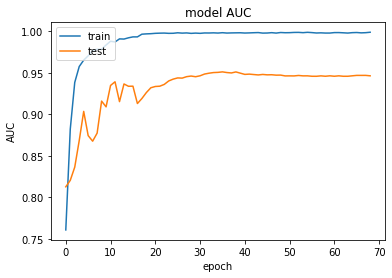

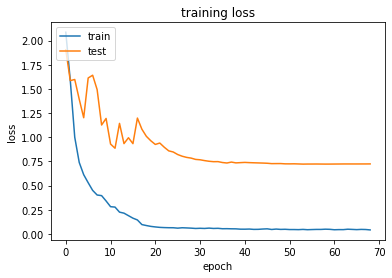

In [11]:
# plt AUC
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plt loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


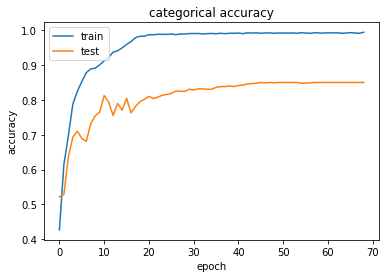

In [12]:
# summarize history for accuracy
plt.plot(history.history['CategoricalAccuracy'])
plt.plot(history.history['val_CategoricalAccuracy'])
plt.title('categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
#supostamente reseta os indices dos arrays
valid_gen.shuffle = False
valid_gen.index_array = None

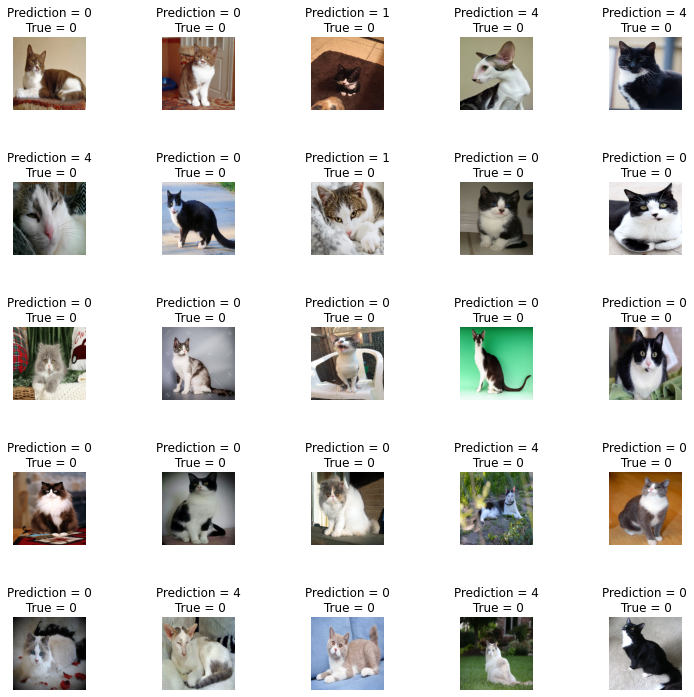

In [14]:
import matplotlib.pyplot as plt
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(valid_gen[0][0], batch_size=batch_size)
for i in np.arange(0,L*W):
    axes[i].imshow(valid_gen[0][0][i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], valid_gen[0][1][i].argmax(axis=0)))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1) 

In [15]:
from sklearn.metrics import classification_report
y_pred0 = model.predict_generator(valid_gen, batch_size)
y_pred1 = np.argmax(y_pred0, axis=1)

y_pred1.shape

print(classification_report(valid_gen.classes, y_pred1,target_names=['bicolor','calico','hairless','point_color','solid_color','tabby_classic','tabby_mackerel','tabby_spotted','tortoiseshell']))

Instructions for updating:
Please use Model.predict, which supports generators.
                precision    recall  f1-score   support

       bicolor       0.75      0.76      0.76        68
        calico       0.80      0.94      0.86        70
      hairless       0.99      1.00      1.00       104
   point_color       0.90      0.96      0.93       124
   solid_color       0.92      0.90      0.91       320
 tabby_classic       0.67      0.76      0.71        55
tabby_mackerel       0.51      0.68      0.58        50
 tabby_spotted       0.87      0.71      0.78       116
 tortoiseshell       0.80      0.28      0.41        29

      accuracy                           0.85       936
     macro avg       0.80      0.78      0.77       936
  weighted avg       0.86      0.85      0.85       936



In [16]:
valid_gen.classes.shape

(936,)

In [17]:
y_pred1.shape

(936,)

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(valid_gen.classes,y_pred1)

0.8504273504273504

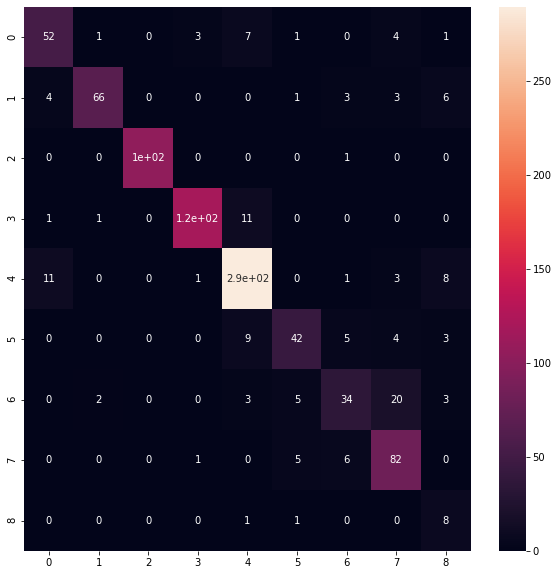

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_pred1,valid_gen.classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True)

In [21]:
model.save('imaginet_8504.h5')